In [1]:
# ARIMA and variant test ( sarimax, sarima etc...)

In [47]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import requests
from io import BytesIO
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(14,4))
plt.rc("font", size=14)

In [57]:
uber = pd.read_csv('../uber_data.csv',index_col = 0,parse_dates = ['pickup_dt'])

In [58]:
uber_serie = uber[uber['borough'] == 'Manhattan']
uber_serie = uber_serie[['pickups']]
#uber_serie = uber_serie[uber_serie.index < '2015-02-01']

In [55]:
uber_serie = uber_serie.asfreq('d')

In [59]:
uber_serie

,pickups
pickup_dt,
2015-01-01 01:00:00,5258
2015-01-01 02:00:00,4345
2015-01-01 03:00:00,4577
2015-01-01 04:00:00,3003
2015-01-01 05:00:00,1313
...,...
2015-06-30 19:00:00,4585
2015-06-30 20:00:00,4210
2015-06-30 21:00:00,4313


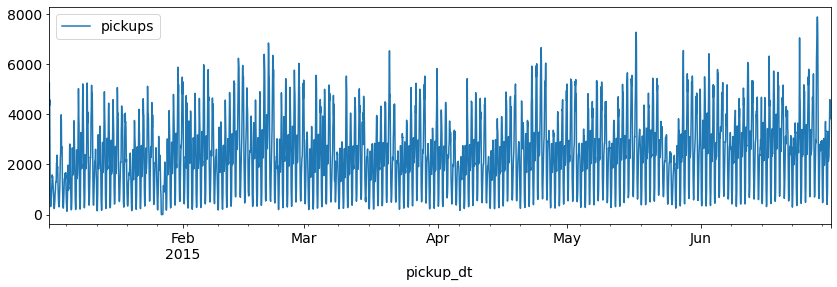

In [60]:
uber_serie.plot()

Evaluer si la série est stationnaire ou non 

In [61]:
from statsmodels.tsa.stattools import adfuller, kpss

In [62]:
adf, pa, *_  = adfuller(uber_serie.dropna())
print("p-value adf : ", pa)

p-value adf :  8.446663211436435e-10


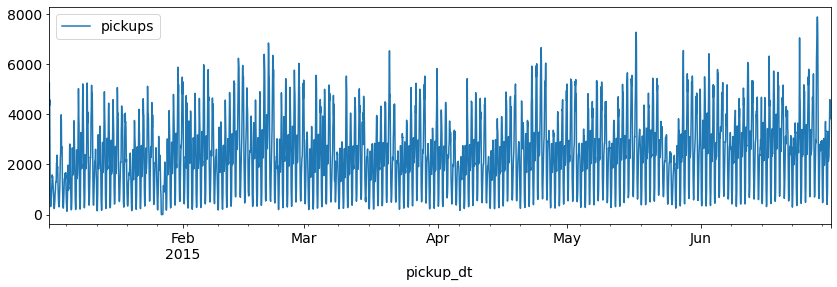

In [63]:
uber_serie.plot()

# lors de l'analyse sur un mois
La P-value est assez elevé, la serie a des chances de ne pas être stationnaire, il va falloir surement passer par une différenciation

# lors de l'analyse sur les 6 mois
La p-value est très faible donc la série est stationnaire
parce que ce que fait la P-value est d'imaginer un monde ou la série n'est pas stationnaire, à quelle point cela serait ridificule, probable ?
donc vu que la p-value est très faible ca rend notre null-hypothesis(null hypothesis => la serie n'est pas stationnaire) complètement ridicule et donc on peut en conclure que notre série est belle et bien stationnaire

In [64]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose

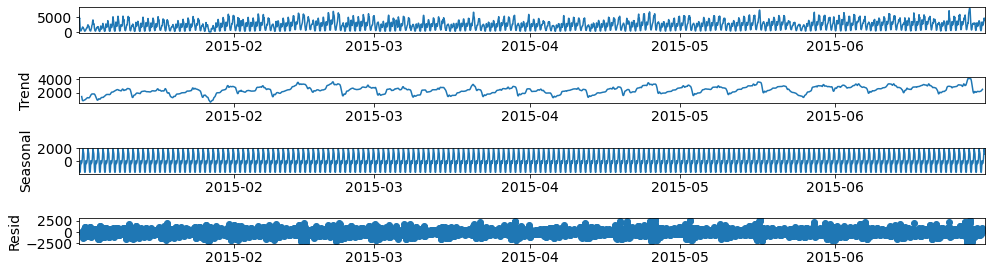

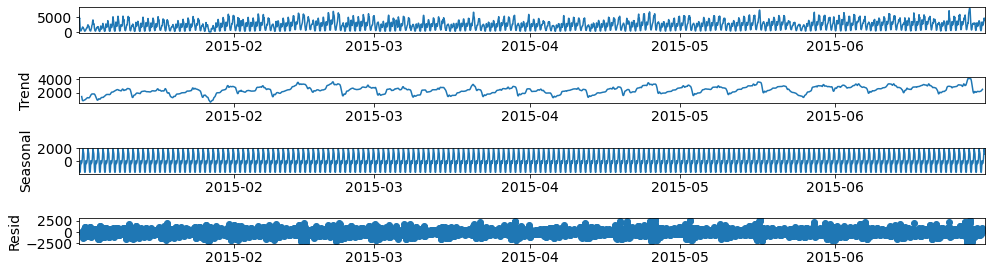

In [65]:
out = seasonal_decompose(uber_serie)
out.plot()

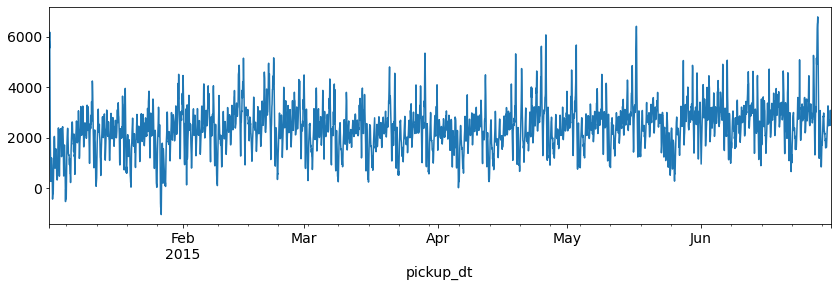

In [66]:
x =  out.observed - out.seasonal
x.plot()

In [67]:
adf, pa, *_  = adfuller(x.dropna())
print("p-value adf : ", pa)

p-value adf :  9.040531776284139e-09


In [68]:
xd =  x.diff(1)
adf, pa, *_  = adfuller(xd.dropna())
print("p-value adf : ", pa)


p-value adf :  0.0


La serie est devenu stationnaire apres une differenciation

# pour les 6 mois<
quoi qu'il arrive la serie est stationnaire car p-value tres bas dans les 2 cas

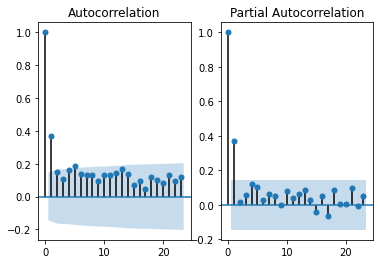

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2)
plot_acf(x.dropna(), ax=ax[0]) 
plot_pacf(x.dropna(), ax=ax[1]);

il semblerait un ordre 4 ou 5 peut etre

In [70]:
#2015-05-07 17:00:00
x_train = x[x.index < '2015-05-07 17:00:00']
x_test = x[x.index >= '2015-05-07 17:00:00']
x_test


pickup_dt
2015-05-07 17:00:00    2845.298213
2015-05-07 18:00:00    3127.870550
2015-05-07 19:00:00    3375.736523
2015-05-07 20:00:00    2825.941847
2015-05-07 21:00:00    3384.057935
                          ...     
2015-06-30 19:00:00    2624.736523
2015-06-30 20:00:00    2482.941847
2015-06-30 21:00:00    2829.057935
2015-06-30 22:00:00    3081.318351
2015-06-30 23:00:00    2680.238259
Length: 1303, dtype: float64

In [77]:
from statsmodels.tsa.arima.model import ARIMA 
mod = ARIMA(x, order=(3,1,0))
res = mod.fit()
res.summary()

/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4343
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -31020.625
Date:                Fri, 16 Oct 2020   AIC                          62049.251
Time:                        17:41:22   BIC                          62074.755
Sample:                    01-01-2015   HQIC                         62058.254
                         - 06-30-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5594      0.010     54.103      0.000       0.539       0.580
ar.L2         -0.2210      0.011    -19.568      0.000      -0.243      -0.199
ar.L3          0.0329      0.011      2.920      0.003       0.011       0.055
sigma2      9.302e+04   1177.189     79.021      0.000    9.07e+04    9.53e+04
===================================================================================
Ljung-Box (Q):                     1349.83   Jarque-Bera (JB):              6255.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
res.aicc

62049.25992803256

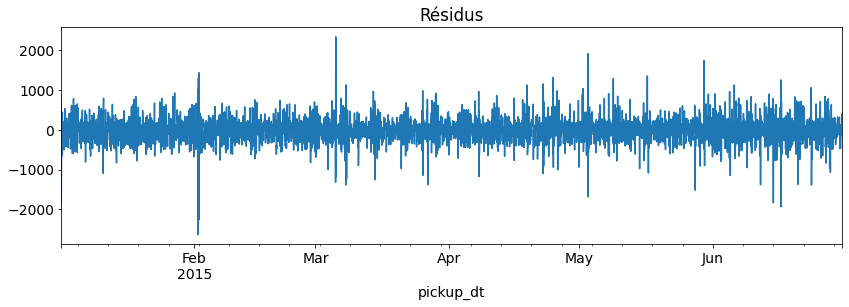

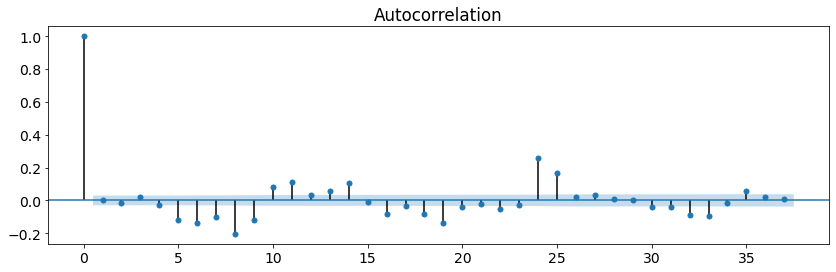

In [79]:
residus = res.resid[2:]
residus.plot(title="Résidus")
plot_acf(residus);

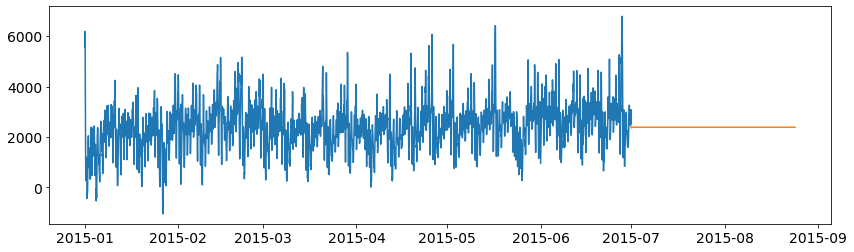

In [81]:
#x.plot()
#res.forecast(5).plot()
plt.plot(x)
plt.plot(res.forecast(len(x_test)))

In [298]:
uber_sarimax = x.copy()

In [299]:
uber_sarimax

pickup_dt
2015-01-01 01:00:00    5791.090136
2015-01-02 01:00:00     887.090136
2015-01-03 01:00:00    -169.481293
2015-01-04 01:00:00     381.280612
2015-01-05 01:00:00     995.494898
2015-01-06 01:00:00    1286.780612
2015-01-07 01:00:00    1256.744898
2015-01-08 01:00:00    1272.090136
2015-01-09 01:00:00    1301.090136
2015-01-10 01:00:00    1194.518707
2015-01-11 01:00:00    2120.280612
2015-01-12 01:00:00    1055.494898
2015-01-13 01:00:00    1418.780612
2015-01-14 01:00:00    1461.744898
2015-01-15 01:00:00    1349.090136
2015-01-16 01:00:00    1324.090136
2015-01-17 01:00:00    1148.518707
2015-01-18 01:00:00    1317.280612
2015-01-19 01:00:00    1534.494898
2015-01-20 01:00:00    1246.780612
2015-01-21 01:00:00    1342.744898
2015-01-22 01:00:00    1336.090136
2015-01-23 01:00:00    1347.090136
2015-01-24 01:00:00    1563.518707
2015-01-25 01:00:00    1515.280612
2015-01-26 01:00:00    1100.494898
2015-01-27 01:00:00     826.780612
2015-01-28 01:00:00    1049.744898
2015-01-29

In [249]:
uber_sarimax = uber_sarimax+1
b = np.log(uber_sarimax)
b

/Users/jerem/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


pickup_dt
2015-01-01 01:00:00    8.681477
2015-01-01 02:00:00    8.595955
2015-01-01 03:00:00    8.685119
2015-01-01 04:00:00    8.406880
2015-01-01 05:00:00    7.942397
                         ...   
2015-01-31 19:00:00    8.103266
2015-01-31 20:00:00    8.285692
2015-01-31 21:00:00    8.222486
2015-01-31 22:00:00    8.304007
2015-01-31 23:00:00    8.452908
Length: 743, dtype: float64

In [300]:
uber_sarimax = uber_sarimax.dropna()

In [251]:
b = b.dropna()

In [252]:
b

pickup_dt
2015-01-01 01:00:00    8.681477
2015-01-01 02:00:00    8.595955
2015-01-01 03:00:00    8.685119
2015-01-01 04:00:00    8.406880
2015-01-01 05:00:00    7.942397
                         ...   
2015-01-31 19:00:00    8.103266
2015-01-31 20:00:00    8.285692
2015-01-31 21:00:00    8.222486
2015-01-31 22:00:00    8.304007
2015-01-31 23:00:00    8.452908
Length: 732, dtype: float64

In [83]:
from statsmodels.tsa.statespace.sarimax import  SARIMAX

#uber_sarimax.index.freq = train.index.inferred_freq

#train = uber_sarimax[:-20]
#test = uber_sarimax[-20:]

mod = SARIMAX(x_train, order=(3,1,0), simple_differencing=False, 
              enforce_stationarity=False, missing= 'drop') 

res = mod.fit()
res.summary()

/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/jerem/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3040
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -21597.733
Date:                Fri, 16 Oct 2020   AIC                          43203.466
Time:                        17:42:33   BIC                          43227.539
Sample:                    01-01-2015   HQIC                         43212.119
                         - 05-07-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.012     48.030      0.000       0.549       0.596
ar.L2         -0.2339      0.012    -18.924      0.000      -0.258      -0.210
ar.L3          0.0498      0.012      3.990      0.000       0.025       0.074
sigma2      8.842e+04   1321.898     66.890      0.000    8.58e+04     9.1e+04
===================================================================================
Ljung-Box (Q):                      982.76   Jarque-Bera (JB):              5601.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.24
Prob(H) (two-sided):                  0.52   Kurtosis:                         9.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
# Utilisation de Bokeh comme backend pour les plots pandas. 
# C'est mon choix, vous faites comme vous voulez
import pandas_bokeh
pandas_bokeh.output_notebook()
pd.set_option("plotting.backend", "pandas_bokeh")


Loading BokehJS ...

In [88]:
pred = res.get_forecast(len(x_test))

In [89]:
pd.concat([x_train, pred.predicted_mean], axis=1).plot(
    colormap=('blue', 'orange', 'gray', 'gray'), legend='bottom_left');

In [90]:
import pickle

pickle.dump(res, open('model_sarimax.pkl','wb'))

In [103]:
predictions = res.predict(start = len(x_train), end=len(x_train)+len(x_test),exog=x_test)



In [106]:
forecast_1= res.forecast(len(x_test), exog=x_test)

In [107]:
forecast_1

2015-05-07 17:00:00    2723.095390
2015-05-07 18:00:00    2713.634424
2015-05-07 19:00:00    2712.429006
2015-05-07 20:00:00    2714.087523
2015-05-07 21:00:00    2714.848552
                          ...     
2015-06-30 19:00:00    2714.734681
2015-06-30 20:00:00    2714.734681
2015-06-30 21:00:00    2714.734681
2015-06-30 22:00:00    2714.734681
2015-06-30 23:00:00    2714.734681
Freq: H, Length: 1303, dtype: float64